# Генеративно-состязательные сети (Generative Adversarial Networks)

В задании предлагается реализовать GAN, обучить её на MNIST, оценить правдоподобие и сделать выводы.

Необходимая теория приведена ниже.

Актуальная версия доступна по адресу https://github.com/nadiinchi/dl_labs/blob/master/lab_gan.ipynb

## Постановка задачи
Дана выборка независимых одинаково распределенных величин из истинного распределения $x_i \sim p_d(x)$, $i = 1, \dots, N$.

Задача - построить вероятностную модель $p_\theta(x)$ истинного распределения $p_d(x)$.

Распределение $p_\theta(x)$ должно позволять как оценить плотность вероятности для данного объекта $x$, так и сэмплировать $x \sim p_\theta(x)$.

## Вероятностная модель
$z \in \mathbb{R}^d$ - локальная латентная переменная, т. е. своя для каждого объекта $x \in \mathbb{R}^D$.

Генеративный процесс вариационного автокодировщика:
1. Сэмплируем $z \sim p(z)$.
2. $x = G_\theta(z)$.

Параметры преобразования $G_\theta(z)$ задаются нейросетью с весами $\theta$, получающей на вход вектор $z$.

Индуцированная генеративным процессом плотность вероятности объекта $x$:

$$p_\theta(x) = \mathbb{E}_{z \sim p(z)} \delta(x = G(z))$$

## Оценка логарифма правдоподобия
Для оценки логарифма правдоподобия используется метод Парзеновского окна/ядерного сглаживания (англ. Kernel Density Estimation/Parzen–Rosenblatt window method). Концептуально он заключается в том, что мы сглаживаем модельное распределение, и по этому сглаженному распределению вычисляем правдоподобие модели.

$$p_\theta(x) = \mathbb{E}_{z \sim p(z)} \delta(x = G(z)) \approx \frac{1}{Mh^D}\sum_{i=1}^M K\left(\frac{x - G_\theta(z_i)}{h}\right)$$

Здесь $K(x)$ - любое распределение, а $h$ - ширина окна. Тогда выполняется

$$\mathbb{E}_{x \sim p_d} \log p_\theta(x) \approx  \frac{1}{N}\sum_{i=1}^{N} \log \frac{1}{Mh^D}\sum_{j=1}^M K\left(\frac{x_i - G_\theta(z_j)}{h}\right)$$

В генеративно-состязательных сетях для оценки правдоподобия используется стандартное нормальное распределение $K(x) = N(x | 0, I)$. Тогда получаем

$$\mathbb{E}_{x \sim p_d} \log p_\theta(x) \approx  \frac{1}{N}\sum_{i=1}^{N} \log \frac{1}{M}\sum_{j=1}^M \prod_{k=1}^D\frac{1}{\sqrt{2 \pi} \sigma}\exp\left(-\frac{(x_{i,k} - G(z_j)_k)^2}{2\sigma^2}\right)$$

Коэффициент $\sigma$ настраивается на валидационной выборке и с его помощью считается правдоподобие тестовой выборки.

### Загрузка, нормировка и визуалиация данных

In [1]:
import math
import torch
from torch import nn
from torch import optim
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

In [2]:
data = MNIST('mnist', download=True, train=True)
train_data = TensorDataset(data.train_data.view(-1, 28 * 28).float() / 255)
data = MNIST('mnist', download=True, train=False)
test_data_raw = TensorDataset(data.test_data.view(-1, 28 * 28).float() / 255)

/home/korobov/anaconda3/envs/torch/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/korobov/anaconda3/envs/torch/lib/python3.7/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [3]:
digit_size = 14

In [4]:
train_data.tensors = (nn.AvgPool2d(2, 2)(train_data.tensors[0].view(-1, 28, 28)).data.view(-1, 196), )
test_data_raw.tensors = (nn.AvgPool2d(2, 2)(test_data_raw.tensors[0].view(-1, 28, 28)).data.view(-1, 196), )

In [5]:
valid_data = TensorDataset(test_data_raw.tensors[0][:5000])
test_data = TensorDataset(test_data_raw.tensors[0][5000:])

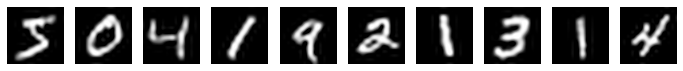

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

def show_images(x):
    plt.figure(figsize=(12, 12 / 10 * (x.shape[0] // 10 + 1)))
    x = x.view(-1, digit_size, digit_size)
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0] // 10 + 1, 10, i + 1)
        plt.imshow(x.data[i].numpy(), cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
        plt.axis('off')

show_images(train_data[:10][0])

In [7]:
n = 15

from scipy.stats import norm
import numpy as np

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

def draw_manifold(generator):
    figure = np.zeros((digit_size * n, digit_size * n))
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])

            x_decoded = generator(z_sample)
            digit = x_decoded
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
    plt.axis('off')
    plt.show()

### Функции и классы, описывающие модель и процесс её обучения

In [8]:
class Reshape(nn.Module):
    def __init__(self, *args):
        """
        Запоминает размерности, в которые при проходе
        вперед будут переводиться все объекты.
        Например,
            input = torch.zeros(100, 196)
            reshape_layer = Reshape(1, 14, 14)
            reshape_layer(input)
        возвращает тензор размерности (100, 1, 14, 14).
            input = torch.zeros(100, 1, 14, 14)
            reshape_layer = Reshape(-1)
            reshape_layer(input)
        наоборот вернет тензор размерности (100, 196).
        """
        super(type(self), self).__init__()
        self.dims = args

    def forward(self, input):
        """
        Возвращает тензор с измененными размерностями объектов.
        Вход: input, FloatTensor.
        Возвращаемое значение: FloatTensor.
        """
        return input.view(input.size(0), *self.dims)

In [9]:
class GAN(nn.Module):
    def __init__(self, d):
        """
        Инициализирует веса модели.
        Вход: d, int - размерность латентного пространства.
        Вход: D, int - размерность пространства объектов.
        """
        super(type(self), self).__init__()
        self.d = d
        # Можно пробовать другие архитектуры: как более сложные
        # сверточные, так и более простые, например, полносвязные.
        # Однако желательно обучить хотя бы одну сверточную модель.
        self.discriminator = nn.Sequential(
            Reshape(1, 14, 14),
            nn.Conv2d(1, 64, 3, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 32, 3, 2, 0, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 16, 3, 1, 0, bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            Reshape(-1),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        self.generator = nn.Sequential(
            Reshape(self.d, 1, 1),
            nn.ConvTranspose2d(self.d, 128, 4, 1, 0, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, 2, 1, 0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 3, 2, 1, 1, bias=False),
            Reshape(-1),
            nn.Sigmoid()
        )

    def generate_noise(self, num_samples):
        """
        Генерирует сэмплы из априорного распределения на z.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Tensor, матрица размера num_samples x d.
        """
        # ваш код здесь
        
        z = torch.normal(0, 1, (num_samples, self.d))
        if next(self.parameters()).is_cuda:
            z = z.cuda()
        return z

    def generate_samples(self, num_samples):
        """
        Генерирует сэмплы из индуцируемого моделью распределения на объекты x.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Tensor, матрица размера num_samples x D.
        """
        # ваш код здесь
        z = self.generate_noise(num_samples)
        return self.generator(z)
        
    def discriminator_loss(self, batch):
        """
        Вычисляет значение функции потерь дискриминатора на данном батче.
        Возвращаемая оценка должна быть дифференцируема по параметрам модели (!).
        Вход: batch, FloatTensor - матрица объектоа размера n x D.
        Возвращаемое значение: Tensor, скаляр - значение функции потерь
        дискриминатора на данном батче.
        """
        
        n = batch.shape[0]        
        return (torch.log(self.discriminator(batch)) + \
                torch.log(1 - self.discriminator(self.generate_samples(n)))).mean()
        
    def generator_loss(self, batch_size):
        """
        Вычисляет значение функции потерь генератора на данном батче.
        Возвращаемая оценка должна быть дифференцируема по параметрам модели (!).
        Вход: batch, FloatTensor - матрица объектоа размера n x D.
        Возвращаемое значение: Tensor, скаляр - значение функции потерь
        генератора на данном батче.
        """
        # поменял лосс в соответствии с советами по ссылке
        # будем его максимизировать
        # https://github.com/soumith/ganhacks
        return torch.log(self.discriminator(self.generate_samples(batch_size))).mean()

In [10]:
def log_mean_exp(mtx):
    """
    Возвращает логарифм среднего по каждому столбцу от экспоненты данной матрицы.
    Подсказка: не забывайте про вычислительную стабильность!
    Вход: mtx, Tensor - матрица размера n x k.
    Возвращаемое значение: Tensor, вектор длины n.
    """
    # ваш код здесь
    k = mtx.shape[1]
    return torch.logsumexp(mtx - np.log(k), dim=1)

In [11]:
def log_likelihood(generated_set, validation_set, test_set, sigma_grid_points=100):
    """
    Возвращает оценку логарифма правдоподобия модели GAN методом
    Парзеновского окна со стандартным нормальным ядром.
    Подсказка: sigma должна настраиваться по валидационной выборке, а
    правдоподобие считаться по тестовой.
    Подсказка: вместо sigma можно настраивать log_sigma.
    Подсказка: для настойки sigma допустимо использовать как перебор по сетке,
    так и другие методы опимизации.
    Вход: generated_set - сэмплы из генеративной модели.
    Вход: validation_set - валидационная выборка.
    Вход: test_set - тестовая выборка.
    Возвращаемое значение: float (не Tensor!) - оценка логарифма правдоподобия.
    """

    D = validation_set.shape[-1]
    def _log_likelihood(log_sigma, input_set):
        # цикл, чтобы не истратить всю память при броадкастинге
        _mtx = torch.empty(input_set.shape[0], 0, device=input_set.device)
        for i in range(generated_set.shape[0]):
            _mtx = torch.cat([_mtx, 
                              (input_set - generated_set[i].unsqueeze(dim=0))\
                              .pow(2).sum(dim=-1, keepdim=True)],
                              dim=1)
        denominator = 0.5 * torch.exp(-2 * log_sigma)
        _mtx = - denominator * _mtx - D * (log_sigma + 0.5 * torch.log(torch.tensor(2 * np.pi)))
        return log_mean_exp(_mtx).mean()

    sigma_logs = torch.linspace(-10, 10, sigma_grid_points)

    imax = 0
    max_ = _log_likelihood(sigma_logs[imax], validation_set)
    for i in range(1, len(sigma_logs)):
        if max_ < _log_likelihood(sigma_logs[i], validation_set):
            max_ = _log_likelihood(sigma_logs[i], validation_set)
            imax = i

    return float(_log_likelihood(sigma_logs[imax], test_set))

In [12]:
def generate_many_samples(model, num_samples, batch_size):
    size = 0
    res = []
    while size < num_samples:
        res.append(model.generate_samples(min(batch_size, num_samples - size)))
        size += batch_size
    return torch.cat(res, 0)

In [13]:
def train_model(model, num_epochs=100, batch_size = 64, lr_generator=2e-4, 
                lr_discriminator=2e-4, betas=(0.5, 0.999), g_steps_per_d=1):
    """
    Обучает модель.
    Вход: model, Module - объект, модель.
    У этого объекта должна быть функция batch_loss от batch - FloatTensor и K - int,
    возвращающая скаляр Variable - функцию потерь на батче, которая должна быть
    оптимизирована.
    Вход: k, int - число итераций оптимизации дискриминатора на итерацию оптимизации
    генератора.
    Вход: batch_size, int.
    Вход: num_epochs, int.
    Вход: learning_rate, float.
    Возвращаемое значение: словарь с полями 'model' - обученная модель,
    'generator_losses' - список значений функции потерь генератора,
    'discriminator_losses' - список значений функции потерь дискриминатора.
    """
    if torch.cuda.is_available():
        model = model.cuda()
    model.train()

    gd_generator = optim.Adam(model.generator.parameters(), lr=lr_generator, betas=betas)
    gd_discriminator = optim.RMSprop(model.discriminator.parameters(), lr=lr_discriminator)

    dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    total_batches = len(dataloader)

    generator_losses = []
    discriminator_losses = []
    log_likelihoods = []

    generated_samples = generate_many_samples(model, 512, batch_size).detach()
    valid_samples = valid_data[np.random.choice(len(valid_data), 512, False)][0]
    valid_samples = valid_samples.to(next(model.parameters()).device)
    test_samples = test_data[np.random.choice(len(test_data), 512, False)][0]
    test_samples = test_samples.to(next(model.parameters()).device)
    ll = log_likelihood(generated_samples, valid_samples, test_samples)
    log_likelihoods.append(ll)
    print('Log-likelihood', ll, flush=True)

    for epoch in range(num_epochs):
        for i, (batch, ) in enumerate(dataloader):
            if torch.cuda.is_available():
                batch = batch.cuda()

                discriminator_loss = model.discriminator_loss(batch)                
                gd_discriminator.zero_grad()
                (-discriminator_loss).backward()
                gd_discriminator.step()
                
                # будем делать несколько шагов обучения генератора
                # на один шаг дискриминатора
                for j in range(g_steps_per_d):
                    generator_loss = model.generator_loss(batch_size)
                    gd_generator.zero_grad()
                    (-generator_loss).backward()
                    gd_generator.step()
            
            # разрешается менять код этой функции для реализации
            # более сложных процедур обучения или ускорения обучения
            # не забудьте корректно сохранить статистику
            discriminator_losses.append(float(discriminator_loss))
            generator_losses.append(float(generator_loss))

            if (i + 1) % 100 == 0:
                print('\rEpoch:', epoch, 'G_loss:', generator_losses[-1],
                      'D_loss:', discriminator_losses[-1],
                      'Batch', i + 1, 'of', total_batches,
                      ' ' * 10, end='', flush=True)
        print(flush=True)
        generated_samples = generate_many_samples(model, 512, batch_size).detach()
        valid_samples = valid_data[np.random.choice(len(valid_data), 512, False)][0]
        valid_samples = valid_samples.to(next(model.parameters()).device)
        test_samples = test_data[np.random.choice(len(test_data), 512, False)][0]
        test_samples = test_samples.to(next(model.parameters()).device)
        ll = log_likelihood(generated_samples, valid_samples, test_samples)
        log_likelihoods.append(ll)
        print('Log-likelihood', ll, flush=True)

    return {
        'model': model.cpu(),
        'generator_losses': generator_losses,
        'discriminator_losses': discriminator_losses,
        'log_likelihoods': log_likelihoods
    }

In [20]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic=True

### Обучение модели

In [21]:
# Подсказка: обучать GANs с скрытой размерностью 2 непросто,
# для этого требуется очень аккуратно подобрать хаки/процесс обучения/
# /архитектуру модели/инициализацию.
# Если не получается сразу, стоит обучить GANs с бОльшей скрытой размерностью,
# а затем вернуться к этой ячейке.
g2 = GAN(2)
# возможно, для обучения модели достаточно/требуется другое число эпох

%time gan_model_d2 = train_model(g2, num_epochs=15, g_steps_per_d=5, batch_size = 32, \
                                  lr_generator=5e-4, lr_discriminator=2e-4)


Log-likelihood -136.8589630126953
Epoch: 0 G_loss: -0.6930698156356812 D_loss: -1.3862470388412476 Batch 1800 of 1875           
Log-likelihood -97.68082427978516
Epoch: 1 G_loss: -0.721498966217041 D_loss: -1.3270151615142822 Batch 1800 of 1875            
Log-likelihood -98.9014892578125
Epoch: 2 G_loss: -0.6754484176635742 D_loss: -1.3971023559570312 Batch 1800 of 1875           
Log-likelihood -4.7162322998046875
Epoch: 3 G_loss: -0.6968299150466919 D_loss: -1.3701565265655518 Batch 1800 of 1875           
Log-likelihood -9.03376293182373
Epoch: 4 G_loss: -0.6922339200973511 D_loss: -1.36849844455719 Batch 1800 of 1875             
Log-likelihood -6.302250385284424
Epoch: 5 G_loss: -0.7077153921127319 D_loss: -1.3846814632415771 Batch 1800 of 1875           
Log-likelihood -0.7553333044052124
Epoch: 6 G_loss: -0.7203682661056519 D_loss: -1.3841100931167603 Batch 1800 of 1875           
Log-likelihood -8.688346862792969
Epoch: 7 G_loss: -0.6896529793739319 D_loss: -1.344902992248535

In [22]:
g10 = GAN(10)
# возможно, для обучения модели достаточно/требу,ется другое число эпох
%time gan_model_d10 = train_model(g10, num_epochs=75, g_steps_per_d=5, batch_size = 128, \
                                  lr_generator=5e-4, lr_discriminator=2e-4, betas=(0.1, 0.999))

Log-likelihood -114.22093200683594
Epoch: 0 G_loss: -0.6846901178359985 D_loss: -1.3944451808929443 Batch 400 of 469           
Log-likelihood -103.0855712890625
Epoch: 1 G_loss: -0.6914634704589844 D_loss: -1.3907651901245117 Batch 400 of 469           
Log-likelihood -46.88618087768555
Epoch: 2 G_loss: -0.6920604705810547 D_loss: -1.3862802982330322 Batch 400 of 469           
Log-likelihood -21.916423797607422
Epoch: 3 G_loss: -0.6932796239852905 D_loss: -1.3864312171936035 Batch 400 of 469           
Log-likelihood -1.4317327737808228
Epoch: 4 G_loss: -0.6935065388679504 D_loss: -1.3862583637237549 Batch 400 of 469           
Log-likelihood 15.464259147644043
Epoch: 5 G_loss: -0.6929547786712646 D_loss: -1.3863394260406494 Batch 400 of 469           
Log-likelihood 22.333637237548828
Epoch: 6 G_loss: -0.6931554675102234 D_loss: -1.3862791061401367 Batch 400 of 469           
Log-likelihood 19.731943130493164
Epoch: 7 G_loss: -0.69305819272995 D_loss: -1.3862831592559814 Batch 400 o

Epoch: 64 G_loss: -0.6935298442840576 D_loss: -1.3853254318237305 Batch 400 of 469           
Log-likelihood 58.705352783203125
Epoch: 65 G_loss: -0.6933413743972778 D_loss: -1.3856658935546875 Batch 400 of 469           
Log-likelihood 62.81666564941406
Epoch: 66 G_loss: -0.6943973302841187 D_loss: -1.3858311176300049 Batch 400 of 469           
Log-likelihood 61.869903564453125
Epoch: 67 G_loss: -0.6933587193489075 D_loss: -1.387794017791748 Batch 400 of 469            
Log-likelihood 60.51944351196289
Epoch: 68 G_loss: -0.694176197052002 D_loss: -1.3871020078659058 Batch 400 of 469            
Log-likelihood 63.33412551879883
Epoch: 69 G_loss: -0.6923116445541382 D_loss: -1.385310411453247 Batch 400 of 469            
Log-likelihood 63.201568603515625
Epoch: 70 G_loss: -0.6927198171615601 D_loss: -1.3857536315917969 Batch 400 of 469           
Log-likelihood 56.12583923339844
Epoch: 71 G_loss: -0.6948175430297852 D_loss: -1.3847739696502686 Batch 400 of 469           
Log-likelihood

In [23]:
g100 = GAN(100)
# возможно, для обучения модели достаточно/требуется другое число эпох
%time gan_model_d100 = train_model(g10, num_epochs=75, g_steps_per_d=2, batch_size = 128, \
                                  lr_generator=5e-4, lr_discriminator=2e-4, betas=(0.1, 0.999))

Log-likelihood 61.493629455566406
Epoch: 0 G_loss: -0.6949599385261536 D_loss: -1.3849741220474243 Batch 400 of 469           
Log-likelihood 60.623435974121094
Epoch: 1 G_loss: -0.6973620653152466 D_loss: -1.382515549659729 Batch 400 of 469            
Log-likelihood 61.26441955566406
Epoch: 2 G_loss: -0.6994799375534058 D_loss: -1.384363055229187 Batch 400 of 469            
Log-likelihood 63.80638122558594
Epoch: 3 G_loss: -0.6966436505317688 D_loss: -1.389981985092163 Batch 400 of 469            
Log-likelihood 62.06342697143555
Epoch: 4 G_loss: -0.7026057243347168 D_loss: -1.379995346069336 Batch 400 of 469            
Log-likelihood 62.8198356628418
Epoch: 5 G_loss: -0.70054030418396 D_loss: -1.384537696838379 Batch 400 of 469              
Log-likelihood 62.76426696777344
Epoch: 6 G_loss: -0.702450156211853 D_loss: -1.382659673690796 Batch 400 of 469             
Log-likelihood 63.31233215332031
Epoch: 7 G_loss: -0.7030316591262817 D_loss: -1.3826266527175903 Batch 400 of 469   

Epoch: 64 G_loss: -0.7553467750549316 D_loss: -1.3240936994552612 Batch 400 of 469           
Log-likelihood 66.31794738769531
Epoch: 65 G_loss: -0.7351967096328735 D_loss: -1.3064581155776978 Batch 400 of 469           
Log-likelihood 63.51304626464844
Epoch: 66 G_loss: -0.780366063117981 D_loss: -1.366760015487671 Batch 400 of 469             
Log-likelihood 64.45803833007812
Epoch: 67 G_loss: -0.7563140392303467 D_loss: -1.326249599456787 Batch 400 of 469            
Log-likelihood 64.32685089111328
Epoch: 68 G_loss: -0.7501710653305054 D_loss: -1.3902757167816162 Batch 400 of 469           
Log-likelihood 60.521148681640625
Epoch: 69 G_loss: -0.7256086468696594 D_loss: -1.3891348838806152 Batch 400 of 469           
Log-likelihood 63.434600830078125
Epoch: 70 G_loss: -0.758388102054596 D_loss: -1.3706145286560059 Batch 400 of 469            
Log-likelihood 66.91731262207031
Epoch: 71 G_loss: -0.7973592281341553 D_loss: -1.3856070041656494 Batch 400 of 469           
Log-likelihood 

### Анализ результатов

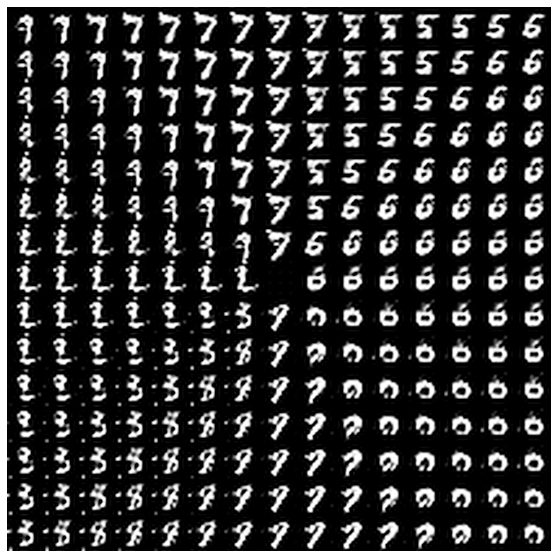

In [24]:
def draw_manifold_gan(model):
    generator = lambda z: model.generator(torch.from_numpy(z).float()).view(digit_size, digit_size).data.numpy()
    return draw_manifold(generator)

draw_manifold_gan(gan_model_d2['model'])

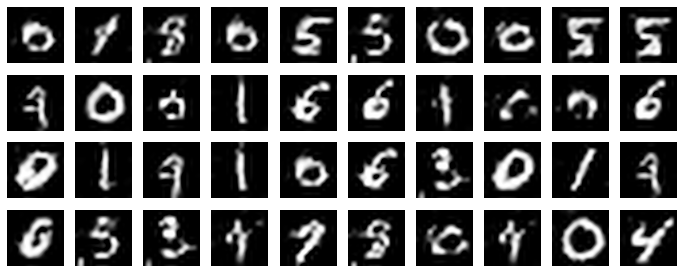

In [25]:
show_images(gan_model_d2['model'].generate_samples(40))

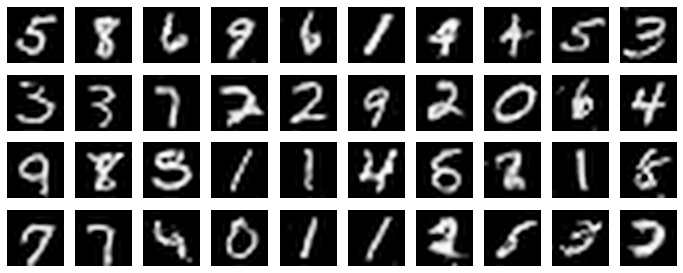

In [26]:
show_images(gan_model_d10['model'].generate_samples(40))

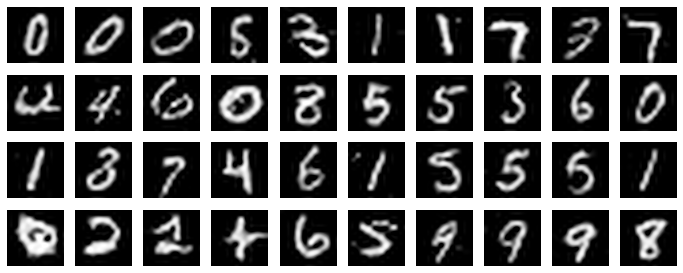

In [27]:
show_images(gan_model_d100['model'].generate_samples(40))

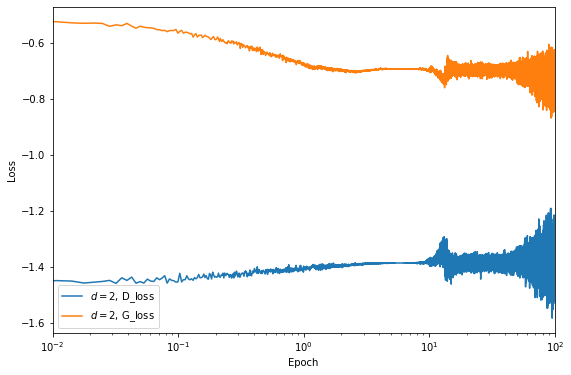

In [28]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('$d = 2$, D_loss', 'discriminator_losses', gan_model_d2),
    ('$d = 2$, G_loss', 'generator_losses', gan_model_d2),
]:
    data = model[name]
    x_labels = (1 + np.arange(len(data))) / len(data) * 100
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmin=0.01, xmax=x_labels[-1])
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
pass

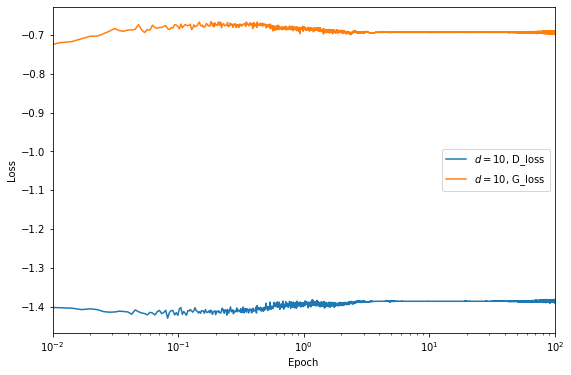

In [29]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('$d = 10$, D_loss', 'discriminator_losses', gan_model_d10),
    ('$d = 10$, G_loss', 'generator_losses', gan_model_d10),
]:
    data = model[name]
    x_labels = (1 + np.arange(len(data))) / len(data) * 100
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmin=0.01, xmax=x_labels[-1])
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
pass

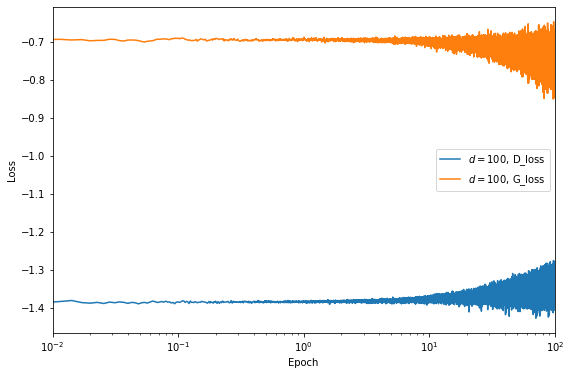

In [30]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('$d = 100$, D_loss', 'discriminator_losses', gan_model_d100),
    ('$d = 100$, G_loss', 'generator_losses', gan_model_d100),
]:
    data = model[name]
    x_labels = (1 + np.arange(len(data))) / len(data) * 100
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmin=0.01, xmax=x_labels[-1])
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
pass

In [34]:
generated_samples = generate_many_samples(gan_model_d2['model'], 4096, 64).detach()
%time log_likelihood(generated_samples, valid_data.tensors[0], test_data.tensors[0], sigma_grid_points=10)

CPU times: user 1h 2min 15s, sys: 4min 36s, total: 1h 6min 52s
Wall time: 14min 17s


-8.650702476501465

In [35]:
generated_samples = generate_many_samples(gan_model_d10['model'], 4096, 64).detach()
%time log_likelihood(generated_samples, valid_data.tensors[0], test_data.tensors[0], sigma_grid_points=10)

CPU times: user 56min 56s, sys: 5min 50s, total: 1h 2min 46s
Wall time: 14min 35s


10.162765502929688

In [36]:
generated_samples = generate_many_samples(gan_model_d100['model'], 4096, 64).detach()
%time log_likelihood(generated_samples, valid_data.tensors[0], test_data.tensors[0], sigma_grid_points=10)

CPU times: user 49min 47s, sys: 2min 56s, total: 52min 44s
Wall time: 10min 53s


10.055232048034668

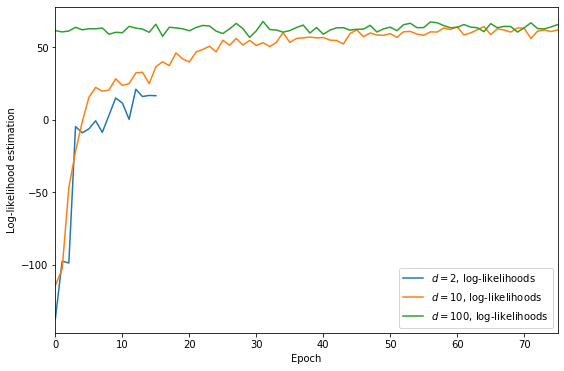

In [37]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('$d = 2$, log-likelihoods', 'log_likelihoods', gan_model_d2),
    ('$d = 10$, log-likelihoods', 'log_likelihoods', gan_model_d10),
    ('$d = 100$, log-likelihoods', 'log_likelihoods', gan_model_d100),
]:
    data = model[name]
    x_labels = np.arange(len(data))
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmin=0.0, xmax=x_labels[-1])
plt.ylabel('Log-likelihood estimation')
plt.legend()
pass

## Выводы
Очень часто дискриминатор в процессе обучания "забивал" генератор: значения его функционала начинали расти очень быстро, а генератора - падать (я сделал хак, при котором нужно максимизировать функционал, отвечающий за генератор). В итоге более менее приличные результаты получились при осциллировании функционалов около некоторых значений.
Модель с латентной размерностью 2 начинает деградировать с большим числом эпох, поэтому она обучалась существенно меньше.

Вывод: GAN'ы действительно тяжело хорошо обучить.